In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
from model import experiment,reliability,inference_utils

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from model import utils
import pandas as pd
from scipy import sparse

import configparser
from configparser import ExtendedInterpolation
sns.set(style="darkgrid")
sns.set_context("notebook")

This notebook solves the arrival model using Gradient Descent algorithm

In [442]:
D=30
S=5
Rep=1
T=5
topics=1
config = configparser.ConfigParser(interpolation=ExtendedInterpolation())
config.read("./configs/config_synthetic.cfg")
data, _ =experiment.experimentArrival(config,iterations=400,verbose=True,fix_phi=True,fix_gamma=True,
                                      simulation="./merged_samples_gd/syn_merged_all-d-1600")

1600
(10,)
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
590842

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +0e+00  0e+00  0e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 

OPTIMAL (within feastol=0.0e+00, reltol=nan, abstol=0.0e+00).
Runtime: 0.000450 seconds.

-37856.754944893866


In [427]:
def unpack(x,shapes):
  ind_pre = 0
  res = []
  #print(x)
  for shape in shapes:
    size = shape[0]*shape[1]
    res.append(x[ind_pre:(ind_pre+size)].reshape(shape))
    ind_pre += size
  return res

def func(x,*args):
  sp_influence,t,documents,sp_influence_cdf,sp_influence_sites,t_diff_cdf,documents_cdf,phi_shape,gamma_shape = args
  phi_temp,gamma = unpack(x,[phi_shape,gamma_shape])
  if lda is None:
    sites_gamma = sp_influence_sites*gamma
  else:
    sites_gamma = (documents*lda).multiply(sp_influence_sites.dot(gamma)).dot(np.ones((lda.shape[1],1)))
  if replications>1:
    phi_d = np.multiply(documents_cdf.T*t_diff_cdf,phi_temp).dot(np.ones((t.shape[1],1)))
  else:
    phi_d = np.multiply(t_diff_cdf,phi_temp).dot(np.ones((t.shape[1],1)))
  #print((sp_influence_sites.dot(gamma)))
  ll_1 = sp_influence.dot(sites_gamma)
  ll =  np.sum(np.log(ll_1 + np.multiply(t,documents*phi_temp).dot(np.ones((t.shape[1],1)))))\
                   -np.sum(sp_influence_cdf*sites_gamma)-np.sum(phi_d)
  return -ll     
        
def funcp(x,*args):
  sp_influence,t,documents,sp_influence_cdf,sp_influence_sites,t_diff_cdf,documents_cdf,phi_shape,gamma_shape = args
  phi_temp,gamma = unpack(x,[phi_shape,gamma_shape])
  if lda is None:
    sites_gamma = sp_influence_sites*gamma
  else:
    sites_gamma = np.asarray((documents*lda).multiply(sp_influence_sites*gamma).dot(np.ones((lda.shape[1],1))))
  if replications>1:
    phi_d = np.multiply(documents_cdf.T*t_diff_cdf,phi_temp).dot(np.ones((t.shape[1],1)))
  else:
    phi_d = np.multiply(t_diff_cdf,phi_temp).dot(np.ones((t.shape[1],1)))
  rond_phi = t/(sp_influence*sites_gamma + (np.multiply(t,documents*phi_temp)).dot(np.ones((t.shape[1],1))))
  rond_phi = documents.T*rond_phi - t_diff_cdf
  
  
  
  sites_gamma_r = sp_influence_sites
  
  
  rond_gamma = np.array(( sp_influence*sites_gamma_r)/(sp_influence*sites_gamma + np.multiply(t,documents*phi_temp).dot(np.ones((t.shape[1],1)))))

  rond_gamma = documents.dot(lda).T.dot(rond_gamma) - sp_influence_cdf.multiply(documents.dot(lda).T).dot(sp_influence_sites)
  rond_gamma = rond_gamma.T
  #print(rond_gamma)
  #rond_gamma = rond_gamma.T.dot(documents.dot(lda).todense()) - sites_gamma_r.T.dot(documents.dot(lda).multiply(sp_influence_cdf.T))
  #- (sp_influence_cdf*sites_gamma_r).T#.dot(documents*lda)
  
  #print((sites_gamma_r.T.dot(documents.dot(lda).multiply(sp_influence_cdf.T))).shape)
  #rond_gamma = rond_gamma 
  x = rond_phi.flatten()
  #x = np.zeros(rond_phi.size)
  x = np.append(x,rond_gamma.flatten())
  return -x


In [428]:
def parse(items,sites_count,documents_count,lda=None,replications=1):
    tDiff,d,t,t_diff_cdf,sp_influence,sp_influence_cdf,sp_influence_sites = items
    documents = sparse.csr_matrix((np.ones(d.shape[0]),(np.arange(d.shape[0]),d/replications)),(d.shape[0],documents_count))
    
    indices = [[d_]*replications for d_ in range(documents_count)]
    indices_flat = np.array([item for sublist in indices for item in sublist])
    documents_cdf = sparse.csr_matrix((np.ones(t_diff_cdf.shape[0]),(np.arange(t_diff_cdf.shape[0]),indices_flat)),(t_diff_cdf.shape[0],documents_count))
    
    return sp_influence,t,documents,sp_influence_cdf,sp_influence_sites,t_diff_cdf,documents_cdf,(documents_count,t.shape[1]),(sites_count,lda.shape[1])

In [443]:
documents_count = data['model']['documents']
sites_count = data['model']['sites']
kernels_mean = data['model']['kernels_arrival']
kernels_length = data['model']['length_arrival']
lda = sparse.csr_matrix(data['model']['membership'])
events = data['data']
max_item = 0
arrivals_bandwidth = data['model']['arrival_bandwidth']
term = np.zeros(data['model']['documents']*data['model']['replications'])+data['T']

items = inference_utils.createDataSetArrival(events,int(documents_count),int(sites_count),int(max_item)+1,
                                             kernels_mean,kernels_length,arrivals_bandwidth,np.asarray(term),-1,max_influence=0)
replications = 1
if lda is None:
    gamma = data['model']['gamma']#np.zeros(sites_count)
else:
    gamma = data['model']['gamma']#np.zeros((sites_count,lda.shape[1]))
phi = data['model']['phi']#np.zeros((int(np.ceil(documents_count)),kernels_mean.shape[0]))
args = parse(items,sites_count,documents_count,lda,replications)
x = phi.flatten()
x = np.append(x,gamma.flatten())
func(x,*args)

(10,)
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending
extending


-37856.754944893866

In [430]:
from scipy import optimize

In [446]:
if lda is None:
    gamma = data['model']['gamma']#np.zeros(sites_count)
else:
    gamma = data['model']['gamma']#np.zeros((sites_count,lda.shape[1]))
phi = data['model']['phi']#np.zeros((int(np.ceil(documents_count)),kernels_mean.shape[0]))


if lda is None:
    gamma = np.zeros(sites_count)+1.0
else:
    gamma = np.zeros((sites_count,lda.shape[1]))+1.0
phi = np.zeros((int(np.ceil(documents_count)),kernels_mean.shape[0]))+1e-1

x = phi.flatten()
x = np.append(x,gamma.flatten())
print(x.size,phi.size,gamma.size)
res = optimize.minimize(func,x0=x,args=args,jac=funcp,method="L-BFGS-B",tol=1e-27,
                  bounds=[(0,None)]*x.shape[0],options={'disp': 10})
ind = data['model']['documents']*data['model']['kernels'].shape[0]
_= (res['x'][:ind],data['model']['phi'].flatten())
_= (res['x'][ind:],data['model']['gamma'].flatten())
phi_,gamma_ = unpack(res['x'],[args[-2],args[-1]])
data['phi'] = phi_
data['gamma'] = gamma_
print(res['status'],res['success'],res['message'])

4820 4800 20
0 True b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [413]:
((data['gamma']-data['model']['gamma'])**2).mean()

0.14161856194235078

In [432]:
((data['gamma']-data['model']['gamma'])**2).mean()

0.13915659652952139

In [436]:
((data['gamma']-data['model']['gamma'])**2).mean()

0.14664994971450099

In [447]:
((data['gamma']-data['model']['gamma'])**2).mean()

5.2198449161863136

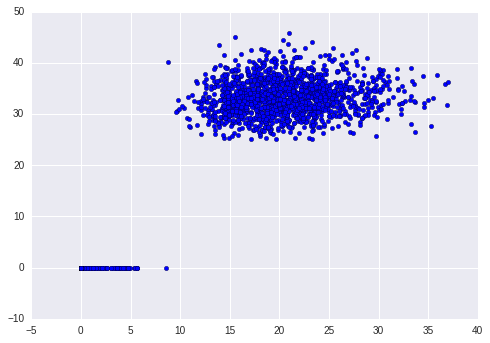

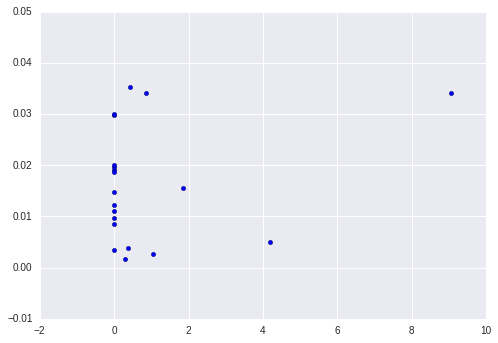

In [448]:
plt.scatter(phi_.flatten(),data['model']['phi'].flatten())
plt.figure()
plt.scatter(gamma_.flatten(),data['model']['gamma'].flatten())

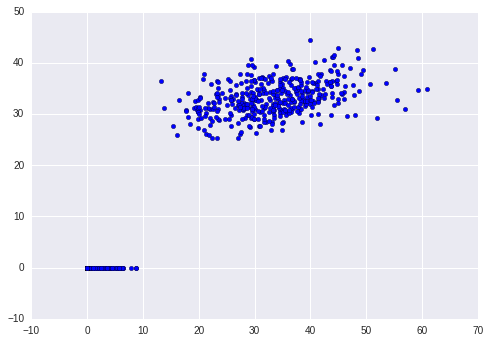

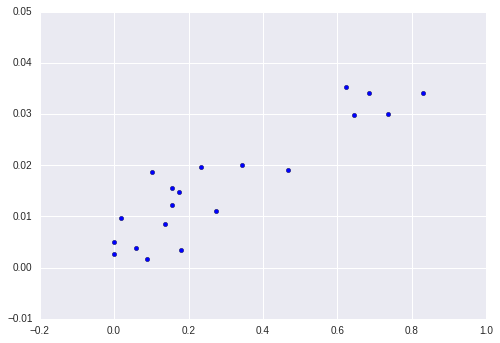

In [402]:
plt.scatter(phi_.flatten(),data['model']['phi'].flatten())
plt.figure()
plt.scatter(gamma_.flatten(),data['model']['gamma'].flatten())

phi estimated [  0.          28.25429736   0.        ]
phi [  0.          31.15787778   0.        ]
arrival [  0.   6.  12.]
survival [  0.   6.  12.]


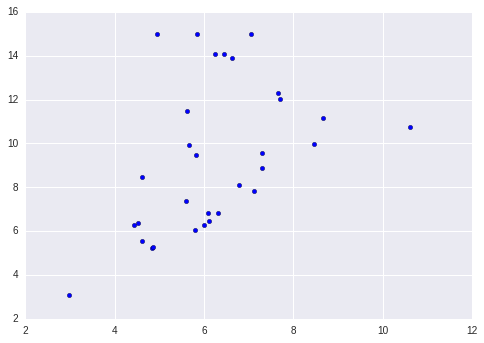

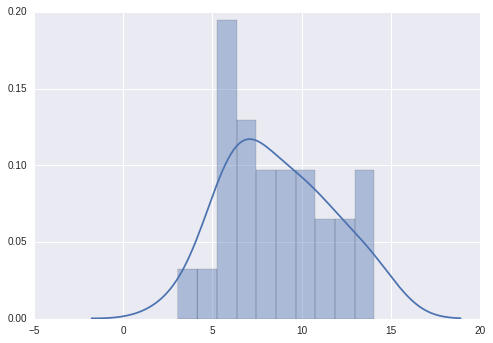

In [403]:
d = 100
#print('beta',data['model']['w'][d,:])
print('phi estimated',data['phi'][d,:])
print('phi',data['model']['phi'][d,:])
print('arrival',data['model']['kernels_arrival'])
print('survival',data['model']['kernels'])
#print('survived',data_2['data']['times_survived'].shape)
times_ = data['data'][d]['times']
times_survived = data['data'][d]['times_survived']
times=np.append(times_,times_survived,axis=0)

sites_ = data['data'][d]['sites']
sites_survived = data['data'][d]['sites_survived']
sites=np.append(sites_,sites_survived)


plt.scatter(times[:,0],times[:,1])
plt.figure()
sns.distplot(times_[:,1],bins=10)

In [200]:
funcp(x,*args)[6]

(2, 24)


0.30527399925279014